In [1]:
#Ignore warnings for a cleaner display
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import keras
import tensorflow as tf
import PIL

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing import image

In [3]:
#Install dependencies
!pip install tf_explain --quiet

In [4]:
from tf_explain.core.grad_cam import GradCAM

# 1. Data Wrangling <a name='1'></a>

## 1.1 Data Loading <a name='1.1'></a>

**Data Source:** 
But we are currently going to use only the first 45,000 images  as a start then update the model step-by-step due to the size of the data (1 GB). 

**The facial keypoints dataset:** this dataset contains the x- and y-coordinates of the facial images' five keypoints (left eye, right eye, nose, left side of the mouth, and right side of the mouth).

Although the original dataset also includes 40 binary values of facial attributes, I will be focusing on the facial keypoints only for now.

### 1.1.1 Loading Keypoints Dataset <a name='1.1.1'></a>

In [5]:
#Define paths to keypoints datasets
keypts_data_path = "../input/celeba-dataset/list_landmarks_align_celeba.csv"
images_data_path = "../input/celeba-dataset/img_align_celeba/img_align_celeba"

#Select only 35k images first
img_data_size = 35000

#Original image dimensions
x_og = 178
y_og = 218

# New image dimensions
x_ = 80
image_size_ratio = x_og / y_og
y_ = int(image_size_ratio * x_)

# Image Sizes
original_image_size = (x_og, y_og)
new_image_size = (x_,y_)

# The image size that will be used in the training process
image_size_training = new_image_size

In [6]:
keypts_og = pd.read_csv(keypts_data_path)[:img_data_size]
keypts_og.sample(5)

,image_id,lefteye_x,lefteye_y,righteye_x,righteye_y,nose_x,nose_y,leftmouth_x,leftmouth_y,rightmouth_x,rightmouth_y
19202,019203.jpg,68,111,109,112,87,136,71,151,106,151
3570,003571.jpg,70,111,107,111,90,138,71,154,106,152
29885,029886.jpg,68,112,109,111,88,140,71,151,105,151
27458,027459.jpg,70,110,107,111,87,136,75,152,103,153
16471,016472.jpg,69,111,108,111,88,131,73,152,104,152


In [7]:
keypts_og.describe()

,lefteye_x,lefteye_y,righteye_x,righteye_y,nose_x,nose_y,leftmouth_x,leftmouth_y,rightmouth_x,rightmouth_y
count,35000.000000,35000.000000,35000.000000,35000.000000,35000.000000,35000.000000,35000.000000,35000.000000,35000.000000,35000.000000
mean,69.368743,111.189143,107.625971,111.153229,88.030029,135.075829,71.282286,152.119200,105.553571,152.215571
std,1.717107,1.128984,1.685886,1.178651,6.702350,4.264796,3.171467,1.795088,3.241235,1.736808
min,60.000000,99.000000,90.000000,99.000000,59.000000,102.000000,60.000000,142.000000,90.000000,139.000000
25%,68.000000,111.000000,107.000000,111.000000,84.000000,133.000000,69.000000,151.000000,103.000000,151.000000
50%,69.000000,111.000000,108.000000,111.000000,88.000000,135.000000,72.000000,152.000000,105.000000,152.000000
75%,70.000000,112.000000,109.000000,112.000000,92.000000,138.000000,74.000000,153.000000,108.000000,153.000000
max,85.000000,121.000000,121.000000,120.000000,120.000000,154.000000,88.000000,168.000000,119.000000,170.000000


In [8]:
keypts_og.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35000 entries, 0 to 34999
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   image_id      35000 non-null  object
 1   lefteye_x     35000 non-null  int64 
 2   lefteye_y     35000 non-null  int64 
 3   righteye_x    35000 non-null  int64 
 4   righteye_y    35000 non-null  int64 
 5   nose_x        35000 non-null  int64 
 6   nose_y        35000 non-null  int64 
 7   leftmouth_x   35000 non-null  int64 
 8   leftmouth_y   35000 non-null  int64 
 9   rightmouth_x  35000 non-null  int64 
 10  rightmouth_y  35000 non-null  int64 
dtypes: int64(10), object(1)
memory usage: 2.9+ MB


In [9]:
keypts_og.shape

(35000, 11)

### 1.1.2 Images Data
Loading the images data involves converting it to arrays so it may be used it in training the model.

In [10]:
images = []

for idx in range(keypts_og.shape[0]):
    #Retrieve path
    path = "{}/{}".format(str(images_data_path), str(keypts_og.iloc[idx].image_id))
    
    #Reading images
    image = PIL.Image.open(path).resize(image_size_training)
    image_array = np.asarray(image) / 255
    
    #Append images
    images.append(image_array)

In [11]:
#Convert to array
images = np.array(images)

images.shape

(35000, 65, 80, 3)

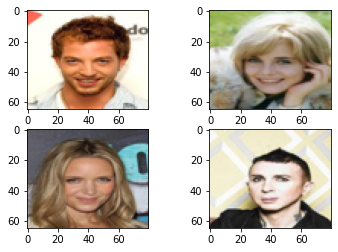

In [12]:
#Plotting sample images
idx1, idx2, idx3, idx4 = np.random.randint(0, img_data_size, size=4)

fig, axs = plt.subplots(2, 2)
axs[0,0].imshow(images[idx1])
axs[1,0].imshow(images[idx2])
axs[1,1].imshow(images[idx3])
axs[0,1].imshow(images[idx4])
plt.show()

## 1.2 Data Cleaning <a name='1.2'></a>
There isn't much to clean in the data since I would like the deep learning to obtain as much of the raw data as possible. However, I will check for any missing values.

In [13]:
#Check for missing values in keypoints dataset
keypts_og.isnull().sum()

image_id        0
lefteye_x       0
lefteye_y       0
righteye_x      0
righteye_y      0
nose_x          0
nose_y          0
leftmouth_x     0
leftmouth_y     0
rightmouth_x    0
rightmouth_y    0
dtype: int64

# 2. EDA
In order to take an initial closer look at the dataset, I want to take a look at the following:
1. Distribution of the keypoints coordinates
2. Heatmap of keypoint coordinates
3. Any correlations

## 2.1 Distribution of the Keypoints Coordinates <a name='2.1'></a>
Since the images dataset is already cropped into nice images with the face roughly centered, I would expect the coordinates to be roughly concentrated around particular areas; for example, the right eye coordinates would be expected to mostly be in the right upper quadrant. If this is not the case, there could be transformed or different types of facial images in the dataset.

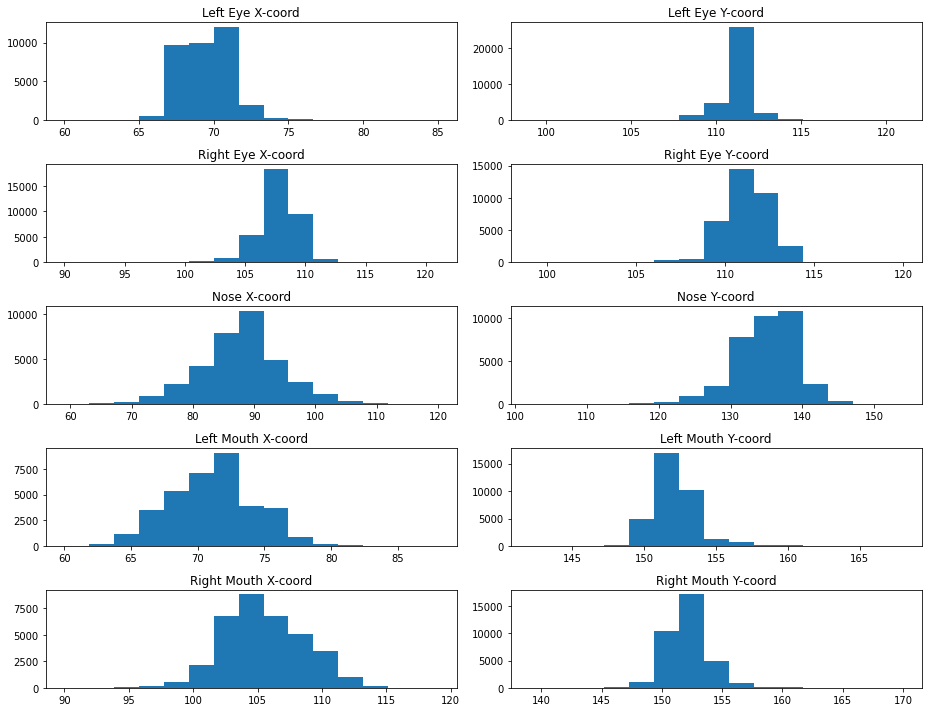

In [14]:
#Plotting distribution of the keypoints' coordinates
fig, axs = plt.subplots(5, 2, figsize=(13,10))

#Left eye
axs[0,0].hist(keypts_og.lefteye_x, bins=15)
axs[0,0].set_title('Left Eye X-coord')
axs[0,1].hist(keypts_og.lefteye_y, bins=15)
axs[0,1].set_title('Left Eye Y-coord')

#Right eye
axs[1,0].hist(keypts_og.righteye_x, bins=15)
axs[1,0].set_title('Right Eye X-coord')
axs[1,1].hist(keypts_og.righteye_y, bins=15)
axs[1,1].set_title('Right Eye Y-coord')

#Nose
axs[2,0].hist(keypts_og.nose_x, bins=15)
axs[2,0].set_title('Nose X-coord')
axs[2,1].hist(keypts_og.nose_y, bins=15)
axs[2,1].set_title('Nose Y-coord')

#Left mouth
axs[3,0].hist(keypts_og.leftmouth_x, bins=15)
axs[3,0].set_title('Left Mouth X-coord')
axs[3,1].hist(keypts_og.leftmouth_y, bins=15)
axs[3,1].set_title('Left Mouth Y-coord')

#Right mouth
axs[4,0].hist(keypts_og.rightmouth_x, bins=15)
axs[4,0].set_title('Right Mouth X-coord')
axs[4,1].hist(keypts_og.rightmouth_y, bins=15)
axs[4,1].set_title('Right Mouth Y-coord')

plt.tight_layout()
plt.show()

## 2.2 Heatmap of General Facial Coordinates<a name='2.2'></a>

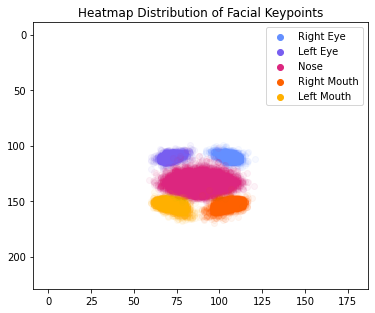

In [15]:
#Plot a sample box of with a heatmap of where the coordinates are
fig, ax = plt.subplots(figsize=(6,6*image_size_ratio))

rect = patches.Rectangle((0, 0), 178, -218, linewidth=4, facecolor='none')
ax.add_patch(rect)

#Add scatter plots of the coordinates with colorblind friendly colors
ax.scatter(keypts_og.righteye_x, -keypts_og.righteye_y, alpha=0.05, color='#648FFF', label='Right Eye')
ax.scatter(keypts_og.lefteye_x, -keypts_og.lefteye_y, alpha=0.05, color='#785EF0', label='Left Eye')
ax.scatter(keypts_og.nose_x, -keypts_og.nose_y, alpha=0.05, color='#DC267F', label='Nose')
ax.scatter(keypts_og.rightmouth_x, -keypts_og.rightmouth_y, alpha=0.05, color='#FE6100', label='Right Mouth')
ax.scatter(keypts_og.leftmouth_x, -keypts_og.leftmouth_y, alpha=0.05, color='#FFB000', label='Left Mouth')

#Add legend for the colors
leg = ax.legend()
#Set legend opacity colors to opaque (1)
for lh in leg.legendHandles:
    lh.set_alpha(1)

#Display positive y-ticks
ax.get_yaxis().set_ticklabels([250, 200, 150, 100, 50, 0])
    
plt.title('Heatmap Distribution of Facial Keypoints')
plt.show()

## 2.3 Correlation between Coordinates <a name='2.3'></a>
I expect there to be some correlation since there is a general relationship between the facial keypoints. For example, the two eyes can only be so far apart, and yet not too close together. At the same time, this rationale would only work for front-facing facial images; the distances would be different in a facial image at an angle.

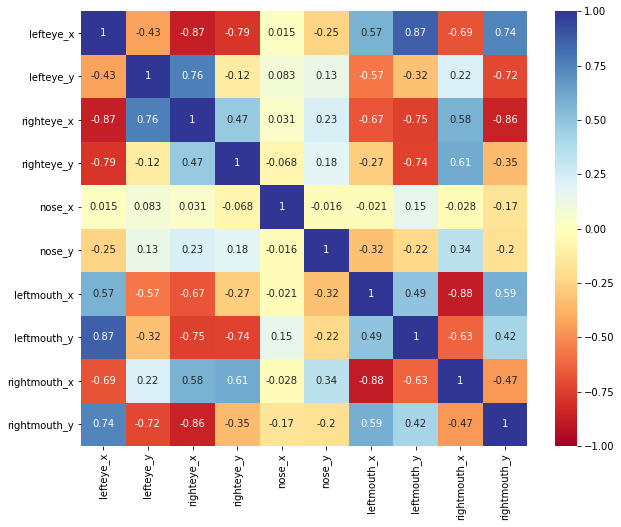

In [16]:
#Correlation map
corrmap = keypts_og.iloc[:,1:].corr()

#Plot heatmap of attributes
plt.subplots(figsize=(10, 8))
sns.heatmap(corrmap, cmap='RdYlBu', vmin=-1, vmax=1, annot=True)
plt.show()

Some of these correlations are surprising. The nose coordinates don't have much correlation to any of the points. The eyes' coordinates all seem to be correlated, except for the left eye y-coordinate with the right eye's.

## Helper Functions

In [17]:
#Read image based on index
def imread_index(index, size=image_size_training, path=images_data_path):
    """This function helps read images based on the its index by converting it to an array.
    """
    path = "{}/{}".format(str(path), str(keypts_og.iloc[index].image_id))
    
    #read the image
    image = PIL.Image.open(path).resize(size)
    image_array = np.asarray(image)
    
    return image_array

In [18]:
#Get a list of all key points of the face
def img_keypts_list(index, df=keypts_og):
    """ This function returns a list of all the key points of the face image so 
    it's easier to plot
    """
    points_list = [df.iloc[index].lefteye_x, df.iloc[index].lefteye_y,
                  df.iloc[index].righteye_x, df.iloc[index].righteye_y,
                  df.iloc[index].nose_x, df.iloc[index].nose_y,
                  df.iloc[index].leftmouth_x, df.iloc[index].leftmouth_y,
                  df.iloc[index].rightmouth_x, df.iloc[index].rightmouth_y]
    
    return points_list

In [19]:
#Plot image with green bounding box and keypoints
def plot_face_bbox(index, df=keypts_og, size=original_image_size):
    """ This function plots the face image with its keypoints and bounding box
    """
    img = imread_index(index, size)
    points_list = img_keypts_list(index, df)
    
    #Plotting the image
    fig, ax = plt.subplots()
    ax.imshow(img)
    
    #Plot the face points
    ax.plot(points_list[::2], points_list[1::2], 'bo-')
    
    #Plot bounding box
    width = abs(points_list[0] - points_list[8] - 60) #obtain width from left eye x to right mouth x
    height = abs(points_list[1] - points_list[9] - 75)#obtain width from left eye y to right mouth y
    rect = patches.Rectangle((points_list[0]-30, points_list[1]-40), width, height, linewidth=4, edgecolor='g', facecolor='none')
    ax.add_patch(rect)
    
    #Remove axis
    plt.axis('off')
    plt.show()

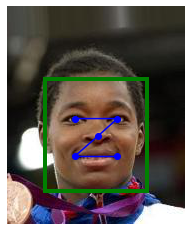

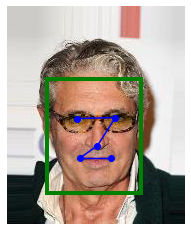

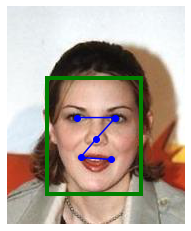

In [20]:
#test
idx1, idx2, idx3 = np.random.randint(0, img_data_size, size=3)

#Test plotting sample images
plot_face_bbox(idx1)
plot_face_bbox(idx2)
plot_face_bbox(idx3)

Since the image sizes were scaled down, the key points also need to be rescaled.

In [21]:
#Copy the original dataframe to leave it intact
keypts = keypts_og.copy()

x_old, y_old = original_image_size
x_new, y_new = image_size_training

#Get ratio of new to old for rescaling
x_ratio = x_new / x_old
y_ratio = y_new / y_old

keypts_x = ['lefteye_x', 'righteye_x', 'nose_x', 'leftmouth_x', 'rightmouth_x']
keypts_y = ['lefteye_y', 'righteye_y', 'nose_y', 'leftmouth_y', 'rightmouth_y']

#Rescale the keypoints
keypts[keypts_x] = (keypts[keypts_x] * x_ratio)
keypts[keypts_y] = (keypts[keypts_y] * y_ratio)

In [22]:
#Check keypoints to see if rescaled, compare with original
keypts_og.head()

,image_id,lefteye_x,lefteye_y,righteye_x,righteye_y,nose_x,nose_y,leftmouth_x,leftmouth_y,rightmouth_x,rightmouth_y
0,000001.jpg,69,109,106,113,77,142,73,152,108,154
1,000002.jpg,69,110,107,112,81,135,70,151,108,153
2,000003.jpg,76,112,104,106,108,128,74,156,98,158
3,000004.jpg,72,113,108,108,101,138,71,155,101,151
4,000005.jpg,66,114,112,112,86,119,71,147,104,150


In [23]:
keypts.head()

,image_id,lefteye_x,lefteye_y,righteye_x,righteye_y,nose_x,nose_y,leftmouth_x,leftmouth_y,rightmouth_x,rightmouth_y
0,000001.jpg,31.011236,32.500000,47.640449,33.692661,34.606742,42.339450,32.808989,45.321101,48.539326,45.917431
1,000002.jpg,31.011236,32.798165,48.089888,33.394495,36.404494,40.252294,31.460674,45.022936,48.539326,45.619266
2,000003.jpg,34.157303,33.394495,46.741573,31.605505,48.539326,38.165138,33.258427,46.513761,44.044944,47.110092
3,000004.jpg,32.359551,33.692661,48.539326,32.201835,45.393258,41.146789,31.910112,46.215596,45.393258,45.022936
4,000005.jpg,29.662921,33.990826,50.337079,33.394495,38.651685,35.481651,31.910112,43.830275,46.741573,44.724771


In [24]:
keypts.describe()

,lefteye_x,lefteye_y,righteye_x,righteye_y,nose_x,nose_y,leftmouth_x,leftmouth_y,rightmouth_x,rightmouth_y
count,35000.000000,35000.000000,35000.000000,35000.000000,35000.000000,35000.000000,35000.000000,35000.000000,35000.000000,35000.000000
mean,31.176963,33.152726,48.371223,33.142018,39.564058,40.274903,32.036982,45.356642,47.439807,45.385377
std,0.771733,0.336624,0.757702,0.351433,3.012292,1.271613,1.425378,0.535233,1.456735,0.517855
min,26.966292,29.518349,40.449438,29.518349,26.516854,30.412844,26.966292,42.339450,40.449438,41.444954
25%,30.561798,33.096330,48.089888,33.096330,37.752809,39.655963,31.011236,45.022936,46.292135,45.022936
50%,31.011236,33.096330,48.539326,33.096330,39.550562,40.252294,32.359551,45.321101,47.191011,45.321101
75%,31.460674,33.394495,48.988764,33.394495,41.348315,41.146789,33.258427,45.619266,48.539326,45.619266
max,38.202247,36.077982,54.382022,35.779817,53.932584,45.917431,39.550562,50.091743,53.483146,50.688073


### Split data into training and test datasets

In [25]:
#Seaparate 20% for the test set
test_size = int(img_data_size * 0.2)

# training data
train_labels = keypts[:img_data_size - test_size]
train_images = images[:img_data_size - test_size]


# test data
test_labels = keypts[img_data_size - test_size + 1:]
test_images = images[img_data_size - test_size + 1:]

### Train and Validation Sets

In [26]:
#Dropping image_id column
y = train_labels.drop(['image_id'], axis = 1) 
X = train_images

# check
y.head(3)

,lefteye_x,lefteye_y,righteye_x,righteye_y,nose_x,nose_y,leftmouth_x,leftmouth_y,rightmouth_x,rightmouth_y
0,31.011236,32.500000,47.640449,33.692661,34.606742,42.339450,32.808989,45.321101,48.539326,45.917431
1,31.011236,32.798165,48.089888,33.394495,36.404494,40.252294,31.460674,45.022936,48.539326,45.619266
2,34.157303,33.394495,46.741573,31.605505,48.539326,38.165138,33.258427,46.513761,44.044944,47.110092


In [27]:
#Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2,random_state = 42)

#Check the ratio
X_val.shape[0]/X_train.shape[0]

0.25

### Building and Training the Model

In [28]:
#Img dimensions
x_ = image_size_training[0]
y_ = image_size_training[1]

#Building the model
model = Sequential()

model.add(Conv2D(filters=8, kernel_size=(3,3), padding='same', activation='relu', input_shape=(y_, x_, 3)))
model.add(Conv2D(filters=8, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=16, kernel_size=(3,3), padding='same', activation='relu'))
model.add(Conv2D(filters=16, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(10, activation='relu'))

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 65, 80, 8)         224       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 65, 80, 8)         584       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 40, 8)         0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 40, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 40, 16)        1168      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 40, 16)        2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 20, 16)        0

In [30]:
#Compile model
model.compile(optimizer='adam', loss='mse', metrics=['mse'])

In [31]:
#Fit model 
training_process = model.fit(X_train, y_train, epochs=300, validation_data=(X_val, y_val), batch_size=200, shuffle=True)

Epoch 1/300
112/112 [==============================] - 11s 34ms/step - loss: 934.8434 - mse: 934.8434 - val_loss: 592.4681 - val_mse: 592.4681
Epoch 2/300
112/112 [==============================] - 3s 23ms/step - loss: 284.1768 - mse: 284.1768 - val_loss: 343.4017 - val_mse: 343.4017
Epoch 3/300
112/112 [==============================] - 2s 22ms/step - loss: 134.1930 - mse: 134.1930 - val_loss: 306.9317 - val_mse: 306.9316
Epoch 4/300
112/112 [==============================] - 2s 21ms/step - loss: 102.3948 - mse: 102.3948 - val_loss: 270.2401 - val_mse: 270.2401
Epoch 5/300
112/112 [==============================] - 2s 22ms/step - loss: 89.8413 - mse: 89.8413 - val_loss: 220.2582 - val_mse: 220.2582
Epoch 6/300
112/112 [==============================] - 3s 23ms/step - loss: 79.7690 - mse: 79.7690 - val_loss: 153.0730 - val_mse: 153.0730
Epoch 7/300
112/112 [==============================] - 2s 21ms/step - loss: 72.0745 - mse: 72.0745 - val_loss: 127.0347 - val_mse: 127.0347
Epoch 8/300

In [32]:
#Load trained model from previous commits to save time
model_path = '../input/model80-35k/model80_35k'
model = keras.models.load_model(model_path)

In [33]:
#Check the loss and accuracy from loaded model to make sure it's same as last time
loss, mse = model.evaluate(test_images, test_labels.drop(['image_id'], axis=1))

219/219 [==============================] - 1s 3ms/step - loss: 0.9944 - mse: 0.9944


### Saving the Model

In [34]:
#Saving the model as SavedModel format
model.save('model80_35k')

In [35]:
#Checking kaggle directory for the file
import os
os.chdir(r'/kaggle/working')
os.listdir()

['model80_35k', '__notebook__.ipynb']

In [36]:
#Obtaining link to download files
from IPython.display import FileLinks
FileLinks(r'model80_35k')

model80_35k/
  saved_model.pb
model80_35k/variables/
  variables.data-00000-of-00001
  variables.index

### Testing the Model

In [37]:
# function to plot the image with green box around the faces
def plot_test_img(index, model, pred_or_actual = 'pred', pointsColor='ro-', boxcolor='g'):
    img = tf.keras.preprocessing.image.load_img("{}/0{}.jpg".format(images_data_path, index),target_size=(y_og,x_og,3))
    img = tf.keras.preprocessing.image.img_to_array(img)
    test_image = img/255
    model = model
    
    #Obtain predictions for key points of face
    if pred_or_actual == 'pred':
        img = tf.keras.preprocessing.image.load_img("{}/0{}.jpg".format(images_data_path, index),target_size=(y_,x_,3))
        img = tf.keras.preprocessing.image.img_to_array(img)
        img = img/255
      
        points_list = model.predict(img.reshape(1,y_,x_,3)).astype('int')[0]
        
        #convert key pts values to original size
        x_ratio = 1.05 * (original_image_size[0] / image_size_training[0])
        y_ratio = 1.085 * (original_image_size[1] / image_size_training[1])
        
        points_list[0] = int(points_list[0] * x_ratio)
        points_list[2] = int(points_list[2] * x_ratio)
        points_list[4] = int(points_list[4] * x_ratio)
        points_list[6] = int(points_list[6] * x_ratio)
        points_list[8] = int(points_list[8] * x_ratio)
    
        points_list[1] = int(points_list[1] * y_ratio)
        points_list[3] = int(points_list[3] * y_ratio)
        points_list[5] = int(points_list[5] * y_ratio)
        points_list[7] = int(points_list[7] * y_ratio)
        points_list[9] = int(points_list[9] * y_ratio)
        
        title = 'Predicted'
        
    elif pred_or_actual == 'actual':      
        points_list = img_keypts_list(index)
        pointsColor = 'bo-'
        title = 'Actual'
    
    # face points
    le_x, le_y, re_x, re_y = points_list[0], points_list[1], points_list[2], points_list[3]
    n_x, n_y = points_list[4], points_list[5]
    lm_x, lm_y, rm_x, rm_y = points_list[6], points_list[7], points_list[8], points_list[9]

    # Create figure and axes
    fig, ax = plt.subplots()
    # plot the image
    ax.imshow(test_image)
    # plot the points on the face
    ax.plot([le_x,re_x,n_x,lm_x,rm_x], [le_y,re_y,n_y,lm_y,rm_y], pointsColor)
    ax.set_title(title)
    
    # plot the box around the face
    width = abs(le_x-rm_x-60)
    height = abs(le_y-rm_y-75)
    rect = patches.Rectangle((le_x-30, le_y-40), width, height, linewidth=4, edgecolor=boxcolor, facecolor='none')
    ax.add_patch(rect);
    return points_list

[70, 111, 107, 111, 84, 133, 74, 153, 103, 153]

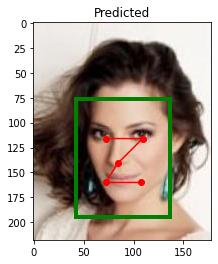

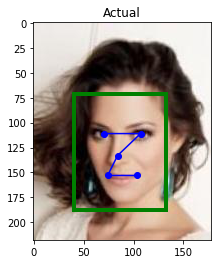

In [38]:
index = 14405
plot_test_img(index, model, pred_or_actual = 'pred')
plot_test_img(index, model, pred_or_actual='actual')

### Evaluation of Model

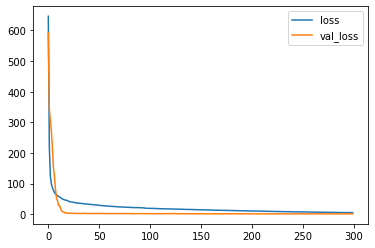

In [39]:
# losses of both training and validation sets
loss = training_process.history['loss']
val_loss = training_process.history['val_loss']

# plot both losses
plt.plot(loss)
plt.plot(val_loss)
plt.legend(['loss', 'val_loss']);

I'd also like to evaluate the model MSE per each coordinate.

In [40]:
#Evaluation function to calculate MSE for each coordinate
def eval_model(labels, predictions, as_df=False):
    """Calculate the MSE for each for ten coordinates, plus an average of all the MSEs, with the option to output as a DataFrame or a list."""
    mse_list = []
    
    #Calculate each MSE and add to list
    for i in np.arange(10):
        if (type(labels)==pd.DataFrame):
            mse_list.append(mean_squared_error(labels.iloc[:,i], [coord[i] for coord in predictions]))
        else:
            mse_list.append(mean_squared_error([label[i] for label in labels], [coord[i] for coord in predictions]))
    
    #Calculate average MSE
    mse_list.append(np.mean(mse_list))
    
    #Optional output as dataframe
    if (as_df):
        cols = keypts_og.columns[1:].tolist()
        cols.append('average')
        
        df = pd.DataFrame(columns=cols)
        df.loc['MSE'] = mse_list
        
        return df
    #Otherwise output as list
    else: return mse_list

In [41]:
test_lbs = test_labels.drop(['image_id'], axis=1)

evaluate = eval_model(test_lbs, model.predict(test_images), as_df=True)
evaluate

,lefteye_x,lefteye_y,righteye_x,righteye_y,nose_x,nose_y,leftmouth_x,leftmouth_y,rightmouth_x,rightmouth_y,average
MSE,0.550627,0.129648,0.659737,0.121735,2.054469,1.611473,1.927429,0.489547,1.936535,0.462328,0.994353


Saving this information in a more accessible .csv file for comparison between models:

In [42]:
# #Load the model csv
# model_data_path = '../input/model-data/model_data.csv'
# exp = pd.read_csv(model_data_path, index_col=0)

In [43]:
exp = pd.DataFrame(data={'loss': [training_process.history['loss']], 
                         'val_loss': [training_process.history['val_loss']],
                         'epoch': 300,
                         'batch': 200,
                        },
                  columns = ['loss', 'val_loss', 'epoch', 'batch'])
exp.rename(index={0: 'Custom'}, inplace=True)
exp

,loss,val_loss,epoch,batch
Custom,"[646.3350830078125, 222.1475372314453, 125.140...","[592.4681396484375, 343.4017333984375, 306.931...",300,200


I lso want to add the mode MSE data. However, since this is a comparison between models and the models use different rescaled images (and keypoint coordinates), MSE is not the best comparison metric since it is scale-dependent. As such, the percentage error will be obtained: the MSE values will be converted to RMSE and standardized, by dividing by the average value and multiplied by 100.

In [44]:
#Add MSE data
exp = pd.concat([exp, evaluate.rename(index={'MSE':'Custom'})], axis=1)
exp

,loss,val_loss,epoch,batch,lefteye_x,lefteye_y,righteye_x,righteye_y,nose_x,nose_y,leftmouth_x,leftmouth_y,rightmouth_x,rightmouth_y,average
Custom,"[646.3350830078125, 222.1475372314453, 125.140...","[592.4681396484375, 343.4017333984375, 306.931...",300,200,0.550627,0.129648,0.659737,0.121735,2.054469,1.611473,1.927429,0.489547,1.936535,0.462328,0.994353


In [45]:
cols = keypts_og.columns[1:].tolist()

for col in cols:
    new_column = 'scaled_' + col
    
    #Convert to RMSE then divide by the coordinate average
    exp.loc['Custom', new_column] = np.sqrt(exp.loc['Custom', col]) / keypts[col].mean() * 100

exp

,loss,val_loss,epoch,batch,lefteye_x,lefteye_y,righteye_x,righteye_y,nose_x,nose_y,...,scaled_lefteye_x,scaled_lefteye_y,scaled_righteye_x,scaled_righteye_y,scaled_nose_x,scaled_nose_y,scaled_leftmouth_x,scaled_leftmouth_y,scaled_rightmouth_x,scaled_rightmouth_y
Custom,"[646.3350830078125, 222.1475372314453, 125.140...","[592.4681396484375, 343.4017333984375, 306.931...",300,200,0.550627,0.129648,0.659737,0.121735,2.054469,1.611473,...,2.3801,1.086083,1.679185,1.052759,3.622839,3.151933,4.333489,1.542611,2.933389,1.498164


In [46]:
#Save dataframe as .csv
exp.to_csv('model_data.csv')

In [47]:
#Download csv
from IPython.display import FileLink
FileLink(r'model_data.csv')

/kaggle/working/model_data.csv

Comparing the distribution of the predicted vs. actual keypoints:

**Currently commented out to save RAM**

In [48]:
# predictions = model.predict(images.reshape(-1,y_,x_,3)).astype('int')
# predictions.shape

In [49]:
# #Obtain keypoint names
# cols = list(keypts.columns)
# cols.remove('image_id')

# #Convert predictions to dataframe
# pred_df = pd.DataFrame(predictions, columns=cols)
# print(pred_df.shape)
# pred_df.sample(3)

In [50]:
# #Plotting distribution of the keypoints' coordinates
# fig, axs = plt.subplots(5, 2, figsize=(13,10))

# #Left eye
# axs[0,0].hist(pred_df.lefteye_x, bins=15, alpha=0.5, color='blue', label='Predicted', width=0.7)
# axs[0,0].hist(keypts.lefteye_x, bins=15, alpha=0.5, color='red', label='Actual')
# axs[0,0].set_title('Left Eye X-coord')
# axs[0,1].hist(pred_df.lefteye_y, bins=15, alpha=0.5, color='blue', label='Predicted', width=0.5)
# axs[0,1].hist(keypts.lefteye_y, bins=15, alpha=0.5, color='red', label='Actual')
# axs[0,1].set_title('Left Eye Y-coord')

# #Right eye
# axs[1,0].hist(pred_df.righteye_x, bins=15, alpha=0.5, color='blue', label='Predicted', width=0.9)
# axs[1,0].hist(keypts.righteye_x, bins=15, alpha=0.5, color='red', label='Actual')
# axs[1,0].set_title('Right Eye X-coord')
# axs[1,1].hist(pred_df.righteye_y, bins=15, alpha=0.5, color='blue', label='Predicted', width=0.5)
# axs[1,1].hist(keypts.righteye_y, bins=15, alpha=0.5, color='red', label='Actual')
# axs[1,1].set_title('Right Eye Y-coord')

# #Nose
# axs[2,0].hist(pred_df.nose_x, bins=15, alpha=0.5, color='blue', label='Predicted', width=0.9)
# axs[2,0].hist(keypts.nose_x, bins=15, alpha=0.5, color='red', label='Actual')
# axs[2,0].set_title('Nose X-coord')
# axs[2,1].hist(pred_df.nose_y, bins=15, alpha=0.5, color='blue', label='Predicted', width=0.9)
# axs[2,1].hist(keypts.nose_y, bins=15, alpha=0.5, color='red', label='Actual')
# axs[2,1].set_title('Nose Y-coord')

# #Left mouth
# axs[3,0].hist(pred_df.leftmouth_x, bins=15, alpha=0.5, color='blue', label='Predicted', width=0.5)
# axs[3,0].hist(keypts.leftmouth_x, bins=15, alpha=0.5, color='red', label='Actual')
# axs[3,0].set_title('Left Mouth X-coord')
# axs[3,1].hist(pred_df.leftmouth_y, bins=15, alpha=0.5, color='blue', label='Predicted', width=0.3)
# axs[3,1].hist(keypts.leftmouth_y, bins=15, alpha=0.5, color='red', label='Actual')
# axs[3,1].set_title('Left Mouth Y-coord')

# #Right mouth
# axs[4,0].hist(pred_df.rightmouth_x, bins=15, alpha=0.5, color='blue', label='Predicted', width=0.7)
# axs[4,0].hist(keypts.rightmouth_x, bins=15, alpha=0.5, color='red', label='Actual')
# axs[4,0].set_title('Right Mouth X-coord')
# axs[4,1].hist(pred_df.rightmouth_y, bins=15, alpha=0.5, color='blue', label='Predicted', width=0.5)
# axs[4,1].hist(keypts.rightmouth_y, bins=15, alpha=0.5, color='red', label='Actual')
# axs[4,1].set_title('Right Mouth Y-coord')

# #Format legend
# lines_labels = [axs[0,0].get_legend_handles_labels()]
# lines, labels = [sum(i, []) for i in zip(*lines_labels)]
# fig.legend(lines, labels, loc='upper center', ncol=2)

# plt.tight_layout()
# plt.show()

### Distribution of MSE

In [51]:
# #Obtain data and their actual keypoint values
# im2 = images.copy()
# actual2 = np.asarray(keypts.drop(['image_id'], axis=1)).transpose().reshape(-1,10).astype(np.float32)

In [52]:
# mse_dist = []

# #Collect MSEs for dataset
# for data in range(im2.shape[0]):
#     loss, mse = model.evaluate(im2[data].reshape(-1, x_, y_, 3), actual2[data].reshape(-1, 10), verbose=0)
#     mse_dist.append(mse)
#     if data%5000 == 0:
#         print("Currently at {}/{} for MSE collection.".format(data, im2.shape[0]))

In [53]:
# #Plot the MSE Distribution
# plt.hist(mse_dist)
# plt.title('MSE Distribution')
# plt.show()

In [54]:
# #Plot RMSE Distribution for easy interpretability
# rmse_dist = np.sqrt(mse_dist)

# plt.hist(rmse_dist)
# plt.title('RMSE Distribution')
# plt.show()

# Explainability of the model

Instead of blindly trusting the 'black box,' I'm going to be delving further into what is going on under the hood to make sure there's some explainability to the model.

In [55]:
#Take a random image from the dataset
IDX = 14404

path = "{}/{}".format(str(images_data_path), str(keypts_og.iloc[IDX].image_id))
im = PIL.Image.open(path).resize(image_size_training)
im_array = np.asarray(im)

im = im_array.reshape(-1, y_, x_, 3)
im.shape

(1, 65, 80, 3)

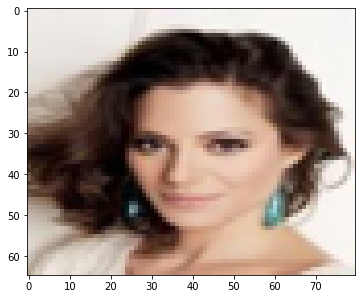

In [56]:
fig = plt.figure(figsize=(6,6*image_size_ratio))
plt.imshow(im_array/255)
plt.show()

In [57]:
#Check the loss and accuracy of the sample image
#Obtain the actual coordinate values and reshape it as a tensor
actual = np.asarray(keypts.iloc[IDX].drop(['image_id'])).transpose().reshape(-1,10).astype(np.float32)

eval_model(actual, model.predict(im), as_df=True)

,lefteye_x,lefteye_y,righteye_x,righteye_y,nose_x,nose_y,leftmouth_x,leftmouth_y,rightmouth_x,rightmouth_y,average
MSE,0.299751,0.822977,9.365943,1.114346,40.492271,10.724735,0.23881,1.039817,10.901856,0.630937,7.563144


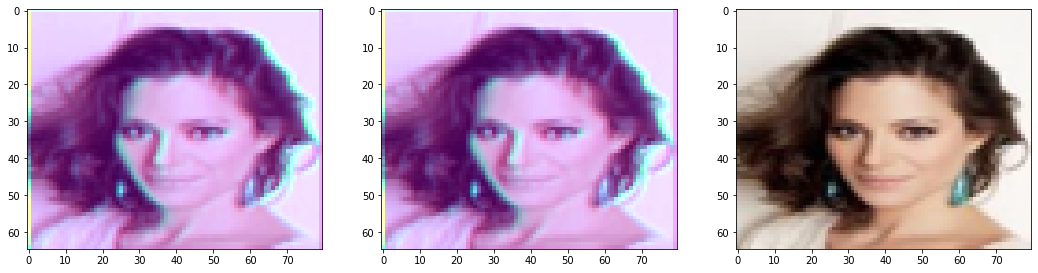

In [58]:
#Visualize GradCAM output from 1st conv layer for left eye y-coord and nose x-coord
explainer = GradCAM()

grid1 = explainer.explain((im, None), model, 1, 'conv2d')
grid2 = explainer.explain((im, None), model, 4, 'conv2d')

#Plot the visualizations
fig = plt.figure(figsize = (18, 8))

ax1 = fig.add_subplot(1, 3, 1)
ax1.imshow(im_array / 255.)
ax1.imshow(grid1, alpha=1)

ax2 = fig.add_subplot(1, 3, 2)
ax2.imshow(im_array / 255.)
ax2.imshow(grid2, alpha=1)

ax3 = fig.add_subplot(1, 3, 3)
ax3.imshow(im_array / 255.)

The model is looking at the edges and outlines of the shapes, which makes sense since it's looking at one of its early layers. Going deeper into the CNN model, however, gives more model explainability.

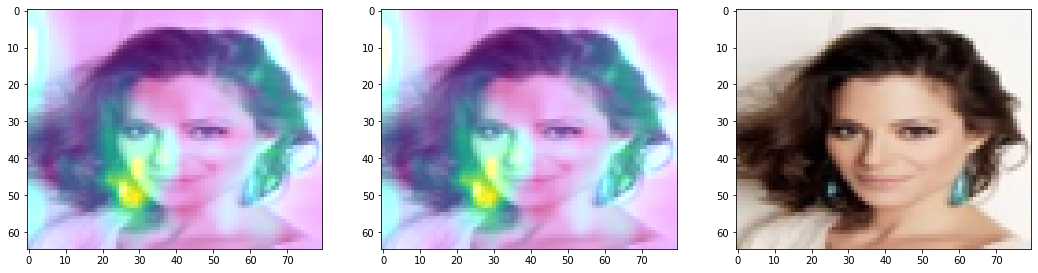

In [59]:
#Visualize GradCAM output from 4th conv layer
grid1 = explainer.explain((im, None), model, 1, 'conv2d_4')
grid2 = explainer.explain((im, None), model, 4, 'conv2d_4')

#Plot the visualizations
fig = plt.figure(figsize = (18, 8))

ax1 = fig.add_subplot(1, 3, 1)
ax1.imshow(im_array / 255.)
ax1.imshow(grid1, alpha=1)

ax2 = fig.add_subplot(1, 3, 2)
ax2.imshow(im_array / 255.)
ax2.imshow(grid2, alpha=1)

ax3 = fig.add_subplot(1, 3, 3)
ax3.imshow(im_array / 255.)

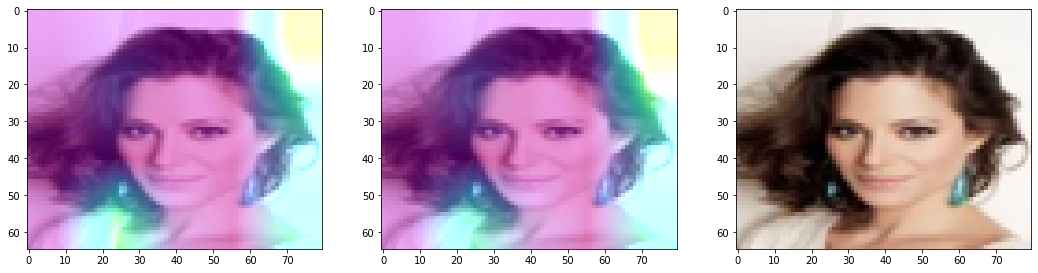

In [60]:
#Visualize GradCAM output from last conv layer
grid1 = explainer.explain((im, None), model, 1, 'conv2d_6')
grid2 = explainer.explain((im, None), model, 4, 'conv2d_6')

#Plot the visualizations
fig = plt.figure(figsize = (18, 8))

ax1 = fig.add_subplot(1, 3, 1)
ax1.imshow(im_array / 255.)
ax1.imshow(grid1, alpha=1)

ax2 = fig.add_subplot(1, 3, 2)
ax2.imshow(im_array / 255.)
ax2.imshow(grid2, alpha=1)

ax3 = fig.add_subplot(1, 3, 3)
ax3.imshow(im_array / 255.)